# Introduction to Jupyter Notebooks
## JupyterLab 🧪

**For an overview of the JupyterLab interface**, see the **JupyterLab Welcome Tour** on this page, by going to `Help -> Welcome Tour` and following the prompts.

> **See Also**: For a more in-depth tour of JupyterLab with a full environment that runs in the cloud, see [the JupyterLab introduction on Binder](https://mybinder.org/v2/gh/jupyterlab/jupyterlab-demo/HEAD?urlpath=lab/tree/demo).


# Sign Language Recognition Notebook
## Introduction

This notebook introduce sign language recognition. Original code can be found in the diverse folders of this repository.

<span style="color:red">**TO DO : add project description**</span>

### Environment
#### Installations

In [1]:
%pip install lsfb_dataset
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Importations

In [12]:
import pandas as pd
import os
from lsfb_dataset import Downloader
import cv2
from cv2 import VideoCapture
import mediapipe as mp
import joblib

## Data Manipulation
### Download dataset

Dataset is based on the LSFB Corpus. This corpus is the result of the tremendous work achieved by the members of the LSFB lab from the university of Namur. LSFB Dataset (lsfb_dataset) is a companion library for the French Belgian Sign Language (LSFB) dataset released by this university. The library provides a set of tools helping to download, manipulate and visualize the data. <br>

> **See More** : For a more in-depth tour of lsfb-dataset, see [lsfb-dataset documentation](https://lsfb-team.github.io/lsfb-dataset/).

**Please be aware that downloading data can take a while.** In order to limit the processing time or take less storage space, you can lower nb_signers.

In [3]:
nb_signers = 8

downloader = Downloader(
    dataset='isol',
    destination="../Database/Dataset",
    splits=['train','test'],
    signers=list(range(nb_signers)),
    include_cleaned_poses=True,
    include_raw_poses=False,
    include_videos=True,
    landmarks=['pose', 'left_hand', 'right_hand'],
    skip_existing_files=True,
)
downloader.download()

Metadata:   0%|          | 0/13 [00:00<?, ?files/s]

Poses for 19926 instances [pose, left_hand, right_hand]:   0%|          | 0/59778 [00:00<?, ?files/s]

Videos for 19926 instances:   0%|          | 0/19926 [00:00<?, ?files/s]

### Select data
The first selection of a video is based on the following criteria : 
 - it has more than 10 frames and less than 50 frames
 - it represents one of the 5 most represented signs of the global databaset
 - the word it represents is represented more than 50 times

> **Warning** : if necessary, please change the following directories to your dataset folder

In [4]:
videos_directory = "../Database/Dataset/videos/" 
df_instances = pd.read_csv('../Database/Dataset/instances.csv', engine='python')
df_index = pd.read_csv('../Database/sign_to_index.csv')

In [5]:
signs = [df_index.loc[i, "sign"] for i in range(5)]
points = [0,4,8,12,16,20]
print(signs)

['AUSSI', 'LS', 'OUI', 'AVOIR', 'SOURD']


How many values for each word ?

In [6]:
def Paths_Videos_Signing(word):
    """return a list of paths of videos signing the parameter word

    Args:
        word (string): word to search in dataset
    Returns:
        list: list of string representing video paths
    """
    videos = []
    df_instances_word = df_instances.loc[df_instances['sign'] == word]
    for title in df_instances_word['id']:
        path = videos_directory + title + ".mp4"
        if os.path.exists(path):
            videos.append(path)
    return videos

In [7]:
for sign in signs:
    print(f"{sign} : {len(Paths_Videos_Signing(sign))}")

AUSSI : 371
LS : 342
OUI : 314
AVOIR : 280
SOURD : 130


Selection based on numeric criteria

In [8]:
minimum_videos = 200 # Nombre minimal de vidéos pour pouvoir garder un mot en base de données
len_min = 10
len_max = 50

In [9]:
def Paths_Selected_Videos(word):
    videos = Paths_Videos_Signing(word)
    selected_videos = []
    for video in videos:
        cap = cv2.VideoCapture(video)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if length>len_min and length<len_max:
            selected_videos.append(video)
    return selected_videos

In [33]:
for sign in signs:
    print(f"Number of videos signing '{sign}' : {len(Paths_Videos_Signing(sign))} before, {len(Paths_Selected_Videos(sign))} after")

Number of videos signing 'AUSSI' : 371 before, 297 after
Number of videos signing 'LS' : 342 before, 297 after
Number of videos signing 'OUI' : 314 before, 265 after
Number of videos signing 'AVOIR' : 280 before, 223 after


In [14]:
for sign in signs:
    if len(Paths_Selected_Videos(sign))<minimum_videos:
        signs.remove(sign)

print("For the rest of the project, we will be working on the following words :")
print(signs)
joblib.dump(signs, "../DataManipulation/Data/Signs.pkl")

For the rest of the project, we will be working on the following words :
['AUSSI', 'LS', 'OUI', 'AVOIR']


['../DataManipulation/Data/Signs.pkl']

### Data formatting
#### Vectorization

<span style="color:red">**TO DO : add MediaPipe documentation**</span>

In [15]:
# Téléchargement du modèle détecteur de mains
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.8)

<span style="color:red">**TO DO : explain the first matrix**</span>
> **Warning**: We put 0 in lacking values because we want to distinguish them from NaN (auto-completion from pandas dataframes)

In [16]:
def Vectorize(video_path, points):
    """return a matrix containing the coordinates of points (according to MediaPipe) that have been extracted from the video saved in directory path

    Args:
        directory (string): path of the video that should be convert in matrix data
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    Returns:
        nparray: matrix corresponding to the following data,
        [[XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20
    """
    capture = VideoCapture(video_path)

    vect = [ [] for i in range(len(points))]
    while capture.isOpened():
        ret, frame = capture.read()
        if not ret:
            break 
        
        #BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# MediaPipe works with RGB format

        # Set flag
        image.flags.writeable = False

        #Detections
        results = hands.process(image)
        rang = 0
        for point in points:
            res = results.multi_hand_world_landmarks
            if res == None: # Without hand detection
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
                vect[rang].append("0")
            else :
                if len(res)>=2: # With a detection of both hands
                    hand = results.multi_hand_world_landmarks[0]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)
                    hand = results.multi_hand_world_landmarks[1]
                    vect[rang].append(hand.landmark[point].x)
                    vect[rang].append(hand.landmark[point].y)
                    vect[rang].append(hand.landmark[point].z)          
                
                elif len(res)==1: # With a one-hand detection
                    res2 = results.multi_handedness[0]
                    label = res2.classification[0].label
                    hand = results.multi_hand_world_landmarks[0]
                    if label == "Left":
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        
                    elif label == "Right" :
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append("0")
                        vect[rang].append(hand.landmark[point].x)
                        vect[rang].append(hand.landmark[point].y)
                        vect[rang].append(hand.landmark[point].z)
                
            rang +=1
        
    return vect

Conversion to dataframe format

In [17]:
def Create_DataFrame(video, points):
    """Create a dataframe based on what Vectorise function returns

    Args:
        video (string): path of the video that will be convert in a dataframe
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>

    Returns:
        dataFrame: dataframe corresponding to the matrix extracted from the video given by Vectorise function
    """
    vect = Vectorize(video, points)
    col = ["Points"]
    
    for i in range(len(vect[0])//6):
        col += [f'xG{i}',f'yG{i}',f'zG{i}',f'xD{i}',f'yD{i}',f'zD{i}']
    
    df = pd.DataFrame(None, columns = col)
    for i in range(len(points)):
        df.loc[len(df.index)] = [f"P{4*i}"] + vect[i]

    return df

Example of the dataframe created from the first video signing "LS" in database

In [18]:
video = Paths_Selected_Videos("LS")[0]
Create_DataFrame(video, points)

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG15,xD15,yD15,zD15,xG16,yG16,zG16,xD16,yD16,zD16
0,P0,-0.035230,0.042146,0.073656,0.066154,0.008858,0.059337,-0.025272,0.046615,0.075060,...,0.075538,0.043564,0.014199,0.079540,0.029654,0.055051,0.074103,0.062954,0.018715,0.057508
1,P4,0.006634,-0.054196,0.005010,-0.001107,-0.074753,-0.000785,0.019382,-0.050444,0.009267,...,-0.000306,-0.025795,-0.061216,0.017933,0.062072,-0.047171,-0.012701,-0.015709,-0.005951,0.025426
2,P8,0.034817,0.017221,0.041634,-0.061179,-0.030260,0.020100,0.055951,0.004189,0.023389,...,-0.042504,-0.027040,-0.051357,-0.033080,-0.019221,-0.061134,-0.048849,-0.035414,-0.060699,-0.012632
3,P12,0.029182,0.012646,0.035624,-0.076076,0.001638,0.029415,0.047710,0.012097,0.028550,...,-0.071690,-0.048773,-0.010769,-0.022032,-0.043118,-0.027342,-0.067052,-0.057198,-0.011822,0.005704
4,P16,0.025709,0.027869,0.028479,-0.060427,0.019197,0.024898,0.044877,0.027482,0.027394,...,-0.057073,-0.057068,0.029403,-0.007605,-0.008420,0.039443,-0.038408,-0.059866,0.037741,0.020737
5,P20,0.033297,0.035249,0.004762,-0.041467,0.057452,0.017356,0.041275,0.039010,0.013481,...,-0.034258,-0.040132,0.061078,0.000094,-0.006039,0.052325,-0.017872,-0.038108,0.067305,0.020124


#### Generalisation
<span style="color:red">**TO DO : correct code about minimum number of videos**</span>

- concat info of every video
- save every video under a unique csv relative to the signed word

In [19]:
def Concatenate_DataFrame(sign, points):
    """concatenate data in a unique dataframe 

    Args:
        sign (list of stirng): list of sign that should be convert in numeric information
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    Returns:
        pd.Dataframe: 
        [[XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4             --> video 1
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20
        
        ...
        
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P0
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P4             --> video N
        ...
        [XG0, YG0, ZG0, XD0, YD0, ZD0, XG1, YG1, ... , XGn, YGn, ZGn, ... ], --> P20]
    """
    videos = Paths_Selected_Videos(sign)
    df = pd.DataFrame(None)

    if len(videos)>=minimum_videos:
        for video in videos:
            df = pd.concat([df,Create_DataFrame(video, points)], ignore_index=True)
    return df

<span style="color:red">**TO DO : add a part for use df without save them under csv ?**</span>

Example for the word "LS"

In [20]:
Concatenate_DataFrame("LS", points)

KeyboardInterrupt: 

In [22]:
def SaveInCSV(sign, points):
    """save dataframe created by Concatenate_DataFrame in csv

    Args:
        sign (string): sign that should be convert in numeric information
        points (list of int): list of index of MediaPipe points, please see documentation <https://developers.google.com/mediapipe/solutions/vision/hand_landmarker>
        
    """
    if not os.path.exists(f'../Database/Positions/{sign}.csv'):
        df = Concatenate_DataFrame(sign, points)
        df.to_csv(f'../Database/Positions/{sign}.csv', index=False)

In [23]:
# Do not execute ~ 17 min
for sign in signs:
    SaveInCSV(sign,points)

### Data processing

Concatenate every sign data before in order to have same length for every X vector

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

In [4]:
signs = joblib.load("../DataManipulation/Data/Signs.pkl")
signs

NameError: name 'joblib' is not defined

In [61]:
List_df_signs = [pd.read_csv(f"../Database/Positions/{sign}.csv") for sign in signs]
df_All = pd.concat(List_df_signs)
df_All

,Points,xG0,yG0,zG0,xD0,yD0,zD0,xG1,yG1,zG1,...,zG47,xD47,yD47,zD47,xG48,yG48,zG48,xD48,yD48,zD48
0,P0,0.0,0.0,0.0,0.0,0.0,0.0,0.015559,0.083049,0.044787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P4,0.0,0.0,0.0,0.0,0.0,0.0,0.034177,-0.023254,-0.028474,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,0.0,0.0,0.0,0.0,0.0,0.0,-0.004072,-0.096158,-0.025613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P12,0.0,0.0,0.0,0.0,0.0,0.0,0.027751,0.022401,-0.015144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P16,0.0,0.0,0.0,0.0,0.0,0.0,0.021707,0.047777,-0.010973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,P4,0.0,0.0,0.0,0.0,0.0,0.0,0.000873,0.024254,0.003159,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1334,P8,0.0,0.0,0.0,0.0,0.0,0.0,0.022978,0.042134,0.039144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1335,P12,0.0,0.0,0.0,0.0,0.0,0.0,0.033054,0.056850,0.027615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336,P16,0.0,0.0,0.0,0.0,0.0,0.0,0.030419,0.054961,0.019449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Convert to numpy to concatenate rows

In [62]:
All = np.array(df_All)
final_vector = []
for i in range (len(All)//len(points)):
    final_vector += [np.concatenate([All[point+i*6][1:] for point in range(6)])]

- Return to Dataframe

In [63]:
df_All = pd.DataFrame(final_vector)
df_All

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015559,0.083049,0.044787,0.006316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012938,0.082440,0.041306,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060475,0.006571,0.077605,0.012307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.049384,0.030766,0.071968,-0.016525,0.074820,0.068859,0.049453,0.028812,0.075394,-0.008487,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.049849,0.021614,0.077442,-0.022396,0.072228,0.072210,0.046102,0.027305,0.079739,-0.012087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001044,0.041654,0.090977,-0.041178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,-0.063210,0.061234,0.047186,0.000000,0.000000,0.000000,0.043812,-0.036999,0.073891,-0.058167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,0.009083,0.077887,0.048610,-0.004348,0.083721,0.034025,0.009551,0.076776,0.058762,-0.008330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Find targets

In [64]:
df_correspondances = pd.read_csv('../Database/sign_to_index.csv')
targets =[]
for num_sign in range(len(signs)):
    ind = 0
    nb_videos = List_df_signs[num_sign].shape[0]//len(points)
    while ind < df_correspondances.shape[0] and df_correspondances.loc[ind, "sign"]!=signs[num_sign]:
        ind+=1
    targets += [ind]*nb_videos
unique, counts = np.unique(targets, return_counts=True)
dict(zip(unique, counts))

{0: 297, 1: 297, 2: 265, 3: 223}

- Concatenate data (X and y)

In [67]:
X = np.array(df_All)
X_training, X_test, y_training, y_test = train_test_split(X, targets, test_size=0.15)

df_training = pd.DataFrame(X_training)
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)

df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010482,0.015072,0.077826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.004989,-0.034713,0.073856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
915,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
916,3,0.011161,0.002662,0.045094,-0.030442,0.050180,0.033386,0.022636,-0.003509,0.055929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
917,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.042946,0.032435,0.076222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df_training.to_csv(f'../DataManipulation/Data/RawTraining.csv', index=False)
df_test.to_csv(f'../DataManipulation/Data/RawTest.csv', index=False)

#### Data Preparation

In [7]:
df_training = pd.read_csv("../DataManipulation/Data/RawTraining.csv")
df_test = pd.read_csv("../DataManipulation/Data/RawTest.csv")

On ne garde que les vidéos dont 99% des valeurs enregistrées (pour sa durée) portent de l'information

In [14]:
def Keep_Indicatives(df_data):
    Data = np.array(df_data)
    ind_video = 0 
    for video in Data:
        number_of_zero = np.count_nonzero(video[1:] == 0)
        nbTotal = np.count_nonzero(video[1:] != np.nan)
        if number_of_zero>0.1*nbTotal:
            Data = np.delete(Data, ind_video, axis=0)
        else:
            ind_video +=1
    return Data

How many videos left ?

In [15]:
df_data = pd.read_csv(f"../DataManipulation/Data/Training.csv")
print(f"Number of videos before 2nd selection on training set : {df_training.shape[0]}")
new = Keep_Indicatives(df_training)
print(f"Number of videos after 2nd selection on training set : {len(new)}")
unique, counts = np.unique(new[:,0], return_counts=True)
dict(zip(unique, counts))

Number of videos before 2nd selection on training set : 919
Number of videos after 2nd selection on training set : 604


{0.0: 184, 1.0: 128, 2.0: 141, 3.0: 151}

In [109]:
df_training = pd.DataFrame(Keep_Indicatives(df_training))
df_test = pd.DataFrame(Keep_Indicatives(df_test))
df_training

,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764
0,2.0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1.0,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Transformer les NaN en 0

In [110]:
Data_training = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_training)
Data_test = SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0).fit_transform(df_test)

In [111]:
X_training = [Data_training[video][1:] for video in range(len(Data_training))]
y_training = [Data_training[video][0] for video in range(len(Data_training))]
X_test = [Data_test[video][1:] for video in range(len(Data_test))]
y_test = [Data_test[video][0] for video in range(len(Data_test))]

In [112]:
df_training = pd.DataFrame(X_training)
df_training.insert(loc=0, column='Target', value=y_training)
df_test = pd.DataFrame(X_test)
df_test.insert(loc=0, column='Target', value=y_test)
df_training

,Target,0,1,2,3,4,5,6,7,8,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,2.0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1.0,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For the rest of the Notebook, we will use Test.csv and Training.csv files as datasets.

In [113]:
df_training.to_csv(f'../DataManipulation/Data/Training.csv', index=False)
df_test.to_csv(f'../DataManipulation/Data/Test.csv', index=False)

## Models
### Support vector machines
#### Importation

In [146]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [23]:
data_training = pd.read_csv("../DataManipulation/Data/Training.csv")
data_test = pd.read_csv("../DataManipulation/Data/Test.csv")

data_training

FileNotFoundError: [Errno 2] No such file or directory: '../DataManipulation/Data/Signs.pkl'

In [151]:
X_training = data_training.drop('Target', axis=1)
y_training = data_training["Target"]
X_test = data_test.drop('Target', axis=1)
y_test =data_test["Target"]
X_training

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,-0.021944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,-0.010324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,-0.014061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,0.012456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,-0.044739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,-0.012464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,-0.024599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,0.037647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Training

In [152]:
SVM_model = svm.SVC(probability=True)
SVM_model.fit(X_training, y_training)

SVC(probability=True)

#### Results

Accuracy

In [157]:
y_pred = SVM_model.predict(X_test)
train_acc = SVM_model.score(X_training, y_training)
print(f"Training accuracy: {train_acc:.04f}")
test_acc = np.sum(y_pred == y_test) / len(y_test)
print(f"Test accuracy: {test_acc:.4f}")

Training accuracy: 0.9421
Test accuracy: 0.8298


In [158]:
print(classification_report(y_training, SVM_model.predict(X_training)))
print(classification_report(y_test, SVM_model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       184
         1.0       0.95      0.94      0.94       128
         2.0       0.98      0.93      0.95       141
         3.0       0.90      0.93      0.91       151

    accuracy                           0.94       604
   macro avg       0.94      0.94      0.94       604
weighted avg       0.94      0.94      0.94       604

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91        30
         1.0       0.80      0.80      0.80        20
         2.0       0.84      0.73      0.78        22
         3.0       0.81      0.77      0.79        22

    accuracy                           0.83        94
   macro avg       0.83      0.82      0.82        94
weighted avg       0.83      0.83      0.83        94



Cross-validation

In [159]:
cv_acc_training = cross_val_score(SVM_model, X_training, y_training, cv=5, scoring="accuracy")
cv_acc_test = cross_val_score(SVM_model, X_test, y_test, cv=5, scoring="accuracy")
print(f"Cross-validation training accuracy: {cv_acc_training}")
print(f"Cross-validation test accuracy: {cv_acc_test}")

Cross-validation training accuracy: [0.7768595  0.80991736 0.80991736 0.78512397 0.76666667]
Cross-validation test accuracy: [0.73684211 0.63157895 0.73684211 0.68421053 0.77777778]


Confusion matrix

Confusion matrix, without normalization
[[29  0  1  0]
 [ 2 16  1  1]
 [ 1  2 16  3]
 [ 2  2  1 17]]
Normalized confusion matrix
[[0.96666667 0.         0.03333333 0.        ]
 [0.1        0.8        0.05       0.05      ]
 [0.04545455 0.09090909 0.72727273 0.13636364]
 [0.09090909 0.09090909 0.04545455 0.77272727]]


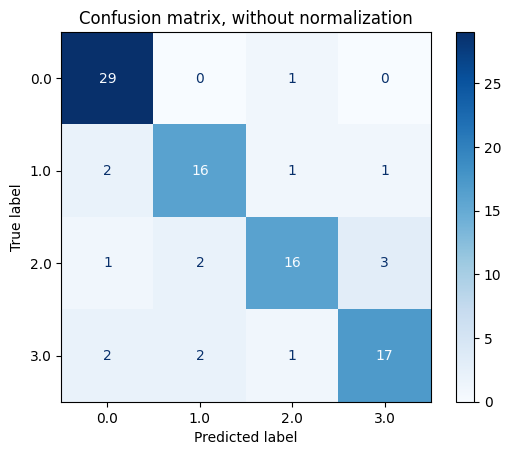

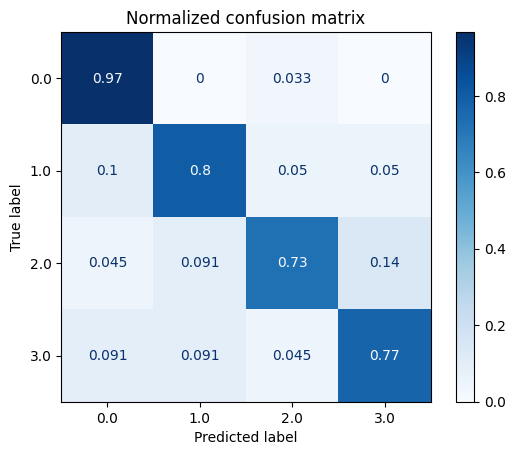

In [160]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        SVM_model,
        X_test,
        y_test,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Neural Network
#### Preparation
Importations

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [3]:
data_training = pd.read_csv("../DataManipulation/Data/Training.csv")
data_test = pd.read_csv("../DataManipulation/Data/Test.csv")

In [4]:
X_training = data_training.drop('Target', axis=1)
y_training = data_training["Target"]
X_test = data_test.drop('Target', axis=1)
y_test =data_test["Target"]
X_training

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,-0.014672,0.084513,-0.028159,-0.015460,0.036203,0.071888,-0.013511,0.087423,-0.024408,-0.021944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,-0.011880,0.035833,0.082438,-0.005975,0.053875,0.075777,-0.010324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014841,0.084725,0.042627,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016561,0.088697,0.039008,-0.014061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.005566,0.020592,0.084844,0.012456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,-0.046215,0.030234,0.072677,0.000000,0.000000,0.000000,0.005872,0.006030,-0.009393,-0.044739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016480,0.058491,0.065937,-0.012464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060749,0.015240,0.063356,-0.024599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034280,0.066748,-0.006117,0.037647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Labels, i.e. fashion categories associated to images (one category per image)
sign_labels = {
    0: "AUSSI",
    1: "LS",
    2: "OUI",
    3: "AVOIR"
}

# Try to change the learning rate to 1e-2 ans check training results
learning_rate = 1
n_epochs = 30
batch_size = 10
inputs = 1764
outputs = 4

Environment

In [6]:
# PyTorch device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA GPU {torch.cuda.get_device_name(0)} found :)")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

No GPU found, using CPU instead


Tensor creation <br>
Be sure to use float32 format for PyTorch tensors

In [7]:
X_training = np.array(X_training)
y_training = np.array(y_training)
X_test = np.array(X_test)
Y_test = np.array(y_test)
X_np = X_training.astype(np.float32)
Y_np = y_training.astype(np.float32)  

In [8]:
X_training = torch.tensor(X_training, dtype=torch.float32).to(device)
y_training = torch.tensor(y_training, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [9]:
print(f"x_train: {X_training.shape}. y_train: {y_training.shape}")
print(f"x_test: {X_test.shape}. y_test: {y_test.shape}")
print(X_training)

x_train: torch.Size([604, 1764]). y_train: torch.Size([604])
x_test: torch.Size([94, 1764]). y_test: torch.Size([94])
tensor([[-0.0147,  0.0845, -0.0282,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0112,  0.0027,  0.0451,  ...,  0.0000,  0.0000,  0.0000]])


In [10]:
sign_train_dataloader = DataLoader(list(zip(X_training,y_training)), batch_size=batch_size)
sign_test_dataloader = DataLoader(list(zip(X_test,y_test)), batch_size=batch_size)

#### Model definition

In [11]:
class NeuralNetwork(nn.Module):
    """Neural network for fashion articles classification"""

    def __init__(self):
        super().__init__()

        # Flatten the input image of shape (1, 28, 28) into a vector of shape (28*28,)
        self.flatten = nn.Flatten()

        # Define a sequential stack of linear layers and activation functions
        self.layer_stack = nn.Sequential(
            # First hidden layer with 784 inputs
            nn.Linear(in_features=1764, out_features=2048),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=1024, out_features=64),
            nn.ReLU(),

            # Output layer
            nn.Linear(in_features=64, out_features=4),
            nn.Softmax()
        )
    def forward(self, x):
        """Define the forward pass of the model"""

        # Apply flattening to input
        x = self.flatten(x)

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits

In [12]:
sign_model = NeuralNetwork().to(device)
print(sign_model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=1764, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
    (7): Softmax(dim=None)
  )
)


In [13]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(sign_model.parameters(), lr=learning_rate)

In [15]:
def epoch_loop(dataloader, model, loss_fn, optimizer):
    """Training algorithm for one epoch"""

    total_loss = 0
    n_correct = 0

    for x_batch, y_batch in dataloader:
        # Load data and targets on device memory
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(x_batch)
        loss = loss_fn(output, y_batch)

        # Backward pass: backprop and GD step
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Accumulate data for epoch metrics: loss and number of correct predictions
            total_loss += loss.item()
            n_correct += (model(x_batch).argmax(dim=1) == y_batch).float().sum().item()

    return total_loss, n_correct

In [16]:
def train_sign(dataloader, model, loss_fn, optimizer):
    """Main training loop"""

    history = {"loss": [], "acc": []}
    n_samples = len(dataloader.dataset)
    n_batches = len(dataloader)

    print(f"Training started! {n_samples} samples. {n_batches} batches per epoch")

    for epoch in range(n_epochs):
        total_loss, n_correct = epoch_loop(dataloader, model, loss_fn, optimizer)

        # Compute epoch metrics
        epoch_loss = total_loss / n_batches
        epoch_acc = n_correct / n_samples

        print(
            f"Epoch [{(epoch + 1):3}/{n_epochs:3}]. Mean loss: {epoch_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

        # Record epoch metrics for later plotting
        history["loss"].append(epoch_loss)
        history["acc"].append(epoch_acc)

    print(f"Training complete! Total gradient descent steps: {n_epochs * n_batches}")

    return history

In [17]:
sign_history = train_sign(
    sign_train_dataloader,
    sign_model,
    loss_fn,
    optimizer,
)

Training started! 604 samples. 61 batches per epoch


C:\Users\della\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [  1/ 30]. Mean loss: 1.38320. Accuracy: 31.79%
Epoch [  2/ 30]. Mean loss: 1.37852. Accuracy: 30.46%
Epoch [  3/ 30]. Mean loss: 1.31179. Accuracy: 39.24%
Epoch [  4/ 30]. Mean loss: 1.21752. Accuracy: 54.30%
Epoch [  5/ 30]. Mean loss: 1.18240. Accuracy: 61.75%
Epoch [  6/ 30]. Mean loss: 1.14756. Accuracy: 65.40%
Epoch [  7/ 30]. Mean loss: 1.12770. Accuracy: 66.06%
Epoch [  8/ 30]. Mean loss: 1.10415. Accuracy: 70.03%
Epoch [  9/ 30]. Mean loss: 1.08102. Accuracy: 72.19%
Epoch [ 10/ 30]. Mean loss: 1.06382. Accuracy: 75.50%
Epoch [ 11/ 30]. Mean loss: 1.04291. Accuracy: 74.67%
Epoch [ 12/ 30]. Mean loss: 1.03172. Accuracy: 76.16%
Epoch [ 13/ 30]. Mean loss: 0.99603. Accuracy: 81.29%
Epoch [ 14/ 30]. Mean loss: 0.97861. Accuracy: 80.96%
Epoch [ 15/ 30]. Mean loss: 0.94684. Accuracy: 82.45%
Epoch [ 16/ 30]. Mean loss: 0.96230. Accuracy: 82.28%
Epoch [ 17/ 30]. Mean loss: 0.98922. Accuracy: 78.81%
Epoch [ 18/ 30]. Mean loss: 0.96777. Accuracy: 80.79%
Epoch [ 19/ 30]. Mean loss: 

#### Results
Accuracy and loss plots

In [18]:
def plot_loss_acc(history):
    """Plot training loss and accuracy. Takes a Keras-like History object as parameter"""

    loss_values = history["loss"]
    recorded_epochs = range(1, len(loss_values) + 1)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(recorded_epochs, loss_values, ".--", label="Training loss")
    ax1.set_ylabel("Loss")
    ax1.legend()

    acc_values = history["acc"]
    ax2.plot(recorded_epochs, acc_values, ".--", label="Training accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.legend()

    final_loss = loss_values[-1]
    final_acc = acc_values[-1]
    fig.suptitle(
        f"Training loss: {final_loss:.5f}. Training accuracy: {final_acc*100:.2f}%"
    )
    plt.show()

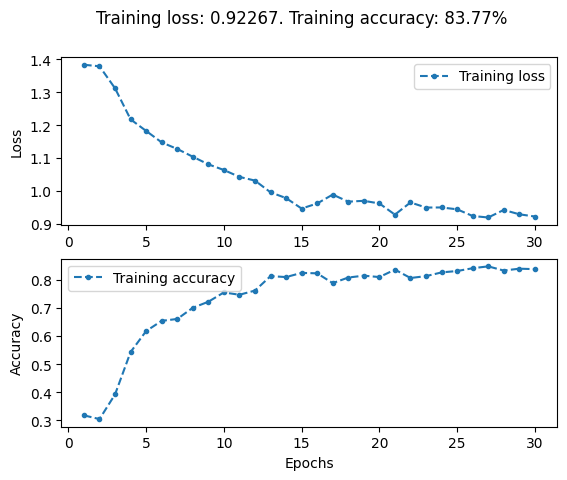

In [26]:
plot_loss_acc(sign_history)

Confusion Matrix

In [27]:
classes = ('AUSSI', 'LS', 'OUI', 'AVOIR')
# Passer les données de test dans le modèle pour obtenir les probabilités
probabilities = sign_model(X_test)

# Obtenir les classes prédites en choisissant l'indice de la classe ayant la probabilité la plus élevée
y_pred = torch.argmax(probabilities, dim=1)

C:\Users\della\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [34]:
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.723404
Precision: 0.783188
Recall: 0.704167
F1 score: 0.691073


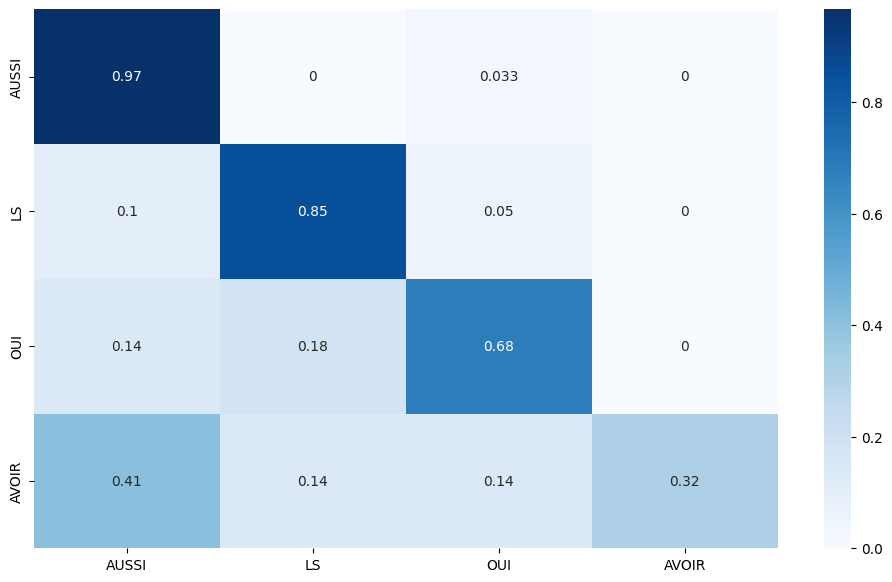

In [21]:
cf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig('output.png')


### From scratch (Course)
#### Layers

In [2]:
def create_layer(input_shape, output_shape):
    """Create a layer of connections between neurons.

    Parameters:
    -----------
        input_shape : int
            Number of input neurons.
        output_shape : int
            Number of output neurons.

    Return
    ------
        array of shape (input_shape, output_shape),
        array of shape (output_shape, )
            w and b, the weights and biases between neurons.
    """
    # Create some uniformly distributed random weights using np.random.uniform
    w = np.random.uniform(-1,1,input_shape*output_shape).reshape((input_shape, output_shape))
    b = np.random.uniform(-1,1,output_shape)
    return w, b

In [3]:
def linear(x, w, b):
    """A linear combination of inputs,
    a.k.a a perceptron with linear activation:

        y = x . w + b

    Parameters:
    -----------
        x : array of shape (n_samples, n)
            Input data.
        w : array of shape (n, m)
            Weight matrix.
        b : array of shape (m, )
            Bias vector.

    Return
    ------
        array of shape (n_samples, m)
            y, the output of the linear transformation.
    """
    # Using np.dot for "dot product" (scalar product)
    res = np.dot(x, w) + b
    return res

In [4]:
def d_linear(x, w, b, with_regard_to="x"):
    """Gradient of the activity of the linear perceptron
    with regard to its parameters (weights and biases) or
    input (x).

    This is exactly like computing the derivative of an affine function,
    but with regard to any of the term in the function:

    y = x . w + b

    ->
        with regard to x:
            dy/dx = w (everything is considered constant except x)

        with regard to w:
            dy/dw = x (everything is considered constant except w)

        with regard to b:
            dy/db = 1 (everything is considered constant except b)

    Parameters
    ----------
        x : array of shape (n_samples, n)
            Input data.
        w : array of shape (n, m)
            Weight matrix.
        b : array of shape (m, )
            Bias vector.
        with_regard_to : "w", "x", "b"
            Take derivative/gradient from parameters w
            or b or from inputs x.

    Return
    ------
        array of shape (m, n) or (n, n_samples) or (1, n_samples)
            Derivative with regard to
    """
    if with_regard_to == "x":
        return w.T
    elif with_regard_to == "w":
        return x.T
    elif with_regard_to == "b":
        return np.ones((1, x.shape[0]))
    else:
        raise ValueError("'with_regard_to' must be equal to 'x', 'w' or 'b'.")

#### Activation function
Tangente

In [5]:
def tanh(x):
    """Hyperbolic tangent activation function tanh(x).

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Simply using np.tanh
    return np.tanh(x)

def d_tanh(x):
    """Hyperbolic tangent derivative tanh'(x).

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Also using np.tanh
    return 1 - np.tanh(x)**2

Sigmoid

In [6]:
def sigmoid(x):
    """Sigmoid activation function σ(x)

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Using np.exp
    return 1/(1+np.exp(-x))


def d_sigmoid(x):
    """Sigmoid derivative function σ'(x)

    Parameters
    ----------
        x : array

    Return
    ------
        array
    """
    # Using the previously defined sigmoid function
    return sigmoid(x) * (1-sigmoid(x))

Loss function

In [7]:
def mse(y_true, y_pred): # Régression
    """Mean Squared Error.

    Parameters
    ----------
        y_true : array of shape (n_samples, )
            Expected response of the model.
        y_pred : array of shape (n_samples, )
            Actual response of the model.

    Return
    ------
        array of shape (1, )
            MSE (square distance) of expected versus actual response.
    """
    # Using np.mean and '**2' to perform 'power(array, 2)'
    res = 1/2*np.mean((y_true-y_pred)**2)
    return res

In [ ]:
input_shape = X_training.shape[1]  # X dimensions (here, 2)
output_shape = 1  # one neuron output

loss_values = []
y_preds = []
all_grad_w = []

all_w = []
all_b = []


#--- PARAMETERS and HYPERPARAMETERS ---

# some random weights to start with
w, b = create_layer(input_shape, output_shape)

# You can also try using some extreme values
# w = np.array([[-10], [10]])
# b = np.array([0])


# Number of epochs (iterations of gradient descent)
n_epochs = 100

# Learning rate
lr = 0.001

#--- TRAINING LOOP ---

for epoch in range(n_epochs):

    #--- PREDICTION (FORWARD PASS) ---

    #--- Layer 0: X_train ---
    # Nothing to do here, X_train virtually enters the network.


    #--- Layer 1 (input to output layer) ---
    # z = w . x + b
    z = linear(X_training,w,b)#généralement on fait plutôt par batch"
    # y = sigmoid(z)
    y = sigmoid(z)

    #--- Loss: L(y_true, y) ---
    loss = nn.CrossEntropyLoss(y_training, y)

    y_preds.append(y)

    # Record everything before updating
    loss_values.append(loss)
    all_w.append(w)
    all_b.append(b)


    #--- BACK PROPAGATION (BACKWARD PASS) ---

    # All gradients and derivatives are marked
    # with "df/dx" notation.
    # Note that this is not rigorous for gradients
    # however.

    # dL/dy
    dL_dy = d_binary_crossentropy(y_training, y)

    # dL/dz = dL/dy * dy/dz
    dL_dz = dL_dy * d_sigmoid(z)
    
    # "dL/dw" (grad L/w) = grad z/w . dL/dz
    grad_z_w = d_linear(X_training, w, b, with_regard_to="w")
    grad_L_w = np.dot(grad_z_w, dL_dz)

    # "dL/db" (grad L/b) = grad z/b . dL/dz
    grad_z_b = d_linear(X_training, w, b, with_regard_to="b")
    grad_L_b = np.dot(grad_z_b, dL_dz)

    ##--- GRADIENT DESCENT ---

    w = w - lr*grad_L_w
    b = b - lr*grad_L_b

    all_grad_w.append(grad_L_w)

In [ ]:
loss = nn.CrossEntropyLoss()

In [53]:
class NeuralNetwork(nn.Module):
    """Neural network for fashion articles classification"""

    def __init__(self):
        super().__init__()

        # Flatten the input image of shape (1, 28, 28) into a vector of shape (28*28,)
        self.flatten = nn.Flatten()

        # Define a sequential stack of linear layers and activation functions
        self.layer_stack = nn.Sequential(
            # First hidden layer with 784 inputs
            nn.Linear(in_features=inputs, out_features=128),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            # Second hidden layer
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),

            # Output layer
            nn.Linear(in_features=64, out_features=outputs),
            nn.Softmax()
        )

    def forward(self, x):
        """Define the forward pass of the model"""

        # Apply flattening to input
        x = self.flatten(x)

        # Compute output of layer stack
        logits = self.layer_stack(x)

        # Logits are a vector of raw (non-normalized) predictions
        # This vector contains 10 values, one for each possible class
        return logits